# 1. Noise-free data


In [12]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import special_ortho_group

## 1.1


In [13]:
def simulate_sir_simple(lam, mu, I_0, T):
    """
    simulates the epidemy using the Euler forward scheme up to day T.
    lam = infection rate
    mu = recovery rate
    I_0 = initial percentage of infected people
    T = days to simulate
    """
    # Initialize variables
    S = 1.0 - I_0
    I = I_0
    R = 0.0

    # Lists to store observations and ODE variables
    X = np.zeros((T, 2))
    C = np.zeros((T, 3))

    for day in range(T):
        # Ensure variables are within bounds
        S = max(min(S, 1.0), 0.0)
        I = max(min(I, 1.0), 0.0)
        R = max(min(R, 1.0), 0.0)

        # Check for population total exceeding 1 due to numerical error
        if S + I + R > 1.0:
            excess = S + I + R - 1.0
            S -= excess * S / (S + I + R)
            I -= excess * I / (S + I + R)
            R -= excess * R / (S + I + R)

        # Calculate new values using Euler forward scheme
        new_infections = lam * S * I
        dS = -new_infections
        dI = new_infections - mu * I
        dR = mu * I

        S += dS
        I += dI
        R += dR

        # Append current values to the lists
        X[day] = [dS, dR]
        C[day] = [S, I, R]

    return X, C

## 1.2


In [14]:
def plot_sir_simulation(C, title='SIR Model Simulation'):
    """
    Plots the SIR simulation results.

    C: Array containing the S, I, R values at each timestep
    T: Total number of days in the simulation
    """
    days = range(len(C))

    # Extract S, I, R values
    S, I, R = C[:, 0], C[:, 1], C[:, 2]

    # Plotting
    plt.figure(figsize=(7, 4))
    plt.plot(days, S, label='Susceptible')
    plt.plot(days, I, label='Infected')
    plt.plot(days, R, label='Recovered')

    plt.xlabel('Days')
    plt.ylabel('Population Proportion')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

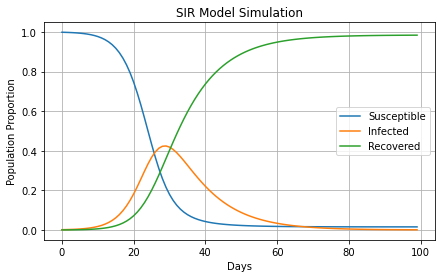

In [15]:
lambda_val = 0.4
mu_val = 0.1
initial_infected = 0.001
num_days = 100

X, C = simulate_sir_simple(lambda_val, mu_val, initial_infected, num_days)

plot_sir_simulation(C)

After some trial and error we found values $\lambda$ = 0.25, $\mu$ = 0.1, and $I_0$ = 0.001 that exhibit interesting and diverse dynamics. Now we look at the ranges of each value where we still see interesting dynamics


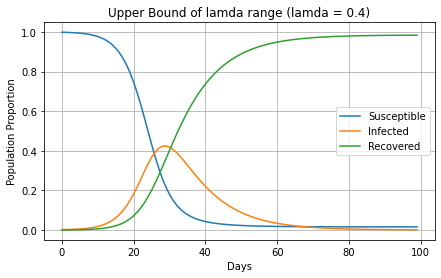

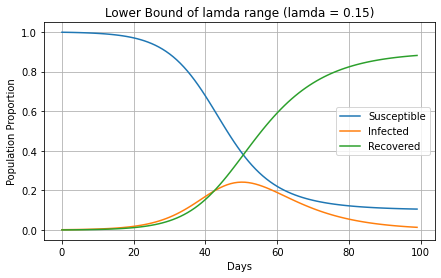

In [16]:
lambda_val_1 = 0.40
lambda_val_2 = 0.25

X_1, C_1 = simulate_sir_simple(
    lambda_val_1, mu_val, initial_infected, num_days)
X_2, C_2 = simulate_sir_simple(
    lambda_val_2, mu_val, initial_infected, num_days)

plot_sir_simulation(C_1, title="Upper Bound of lamda range (lamda = 0.4)")
plot_sir_simulation(C_2, title="Lower Bound of lamda range (lamda = 0.15)")

So lambda should be in the range between $\lambda = [0.25, 0.4]$. Lets do the same with $\mu$ and $I_0$


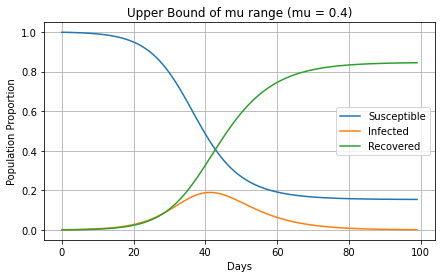

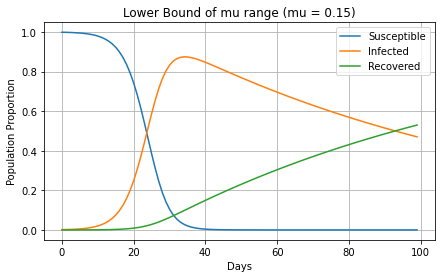

In [17]:
mu_val_1 = 0.15
mu_val_2 = 0.01
lambda_val = 0.325

X_1, C_1 = simulate_sir_simple(
    lambda_val, mu_val_1, initial_infected, num_days)
X_2, C_2 = simulate_sir_simple(
    lambda_val, mu_val_2, initial_infected, num_days)

plot_sir_simulation(C_1, title="Upper Bound of mu range (mu = 0.4)")
plot_sir_simulation(C_2, title="Lower Bound of mu range (mu = 0.15)")

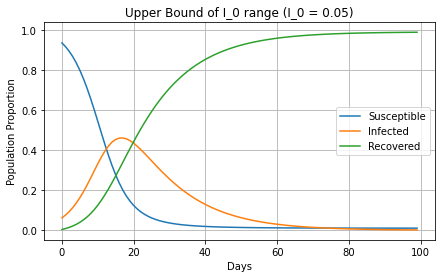

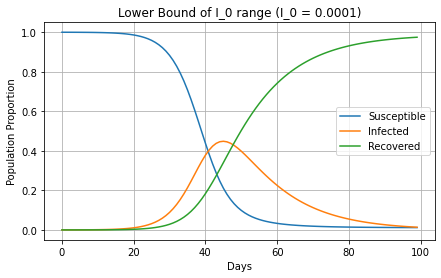

In [18]:
mu_val = 0.075
initial_infected_1 = 0.05
initial_infected_2 = 0.0001


X_1, C_1 = simulate_sir_simple(
    lambda_val, mu_val, initial_infected_1, num_days)
X_2, C_2 = simulate_sir_simple(
    lambda_val, mu_val, initial_infected_2, num_days)

plot_sir_simulation(C_1, title="Upper Bound of I_0 range (I_0 = 0.05)")
plot_sir_simulation(C_2, title="Lower Bound of I_0 range (I_0 = 0.0001)")

From our test we get suitable range of:  
$\lambda = [0.25, 0.4]$
$\mu = [0.01, 0.15]$
$I_0 = [0.0001, 0.05]$


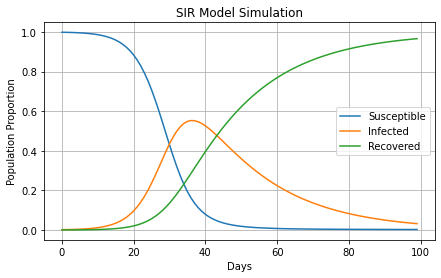

In [19]:
lambda_val = 0.3
mu_val = 0.05
initial_infected = 0.001
num_days = 100

X, C = simulate_sir_simple(lambda_val, mu_val, initial_infected, num_days)

plot_sir_simulation(C)

## 1.3


First, we define a dataset for training:


In [20]:
class SIRDataset(Dataset):
    def __init__(self, size, T):
        self.size = size
        self.T = T
        self.data = []
        self.targets = []

        lam_prior = np.random.uniform(0.25, 0.4, size=size)
        mu_prior = np.random.uniform(0.01, 0.15, size=size)
        I_0_prior = np.random.uniform(0.0001, 0.05, size=size)

        for i in range(size):
            lam = lam_prior[i]
            mu = mu_prior[i]
            I_0 = I_0_prior[i]
            X, _ = simulate_sir_simple(lam, mu, I_0, T)
            self.data.append(X)
            self.targets.append([lam, mu, I_0])

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)

Next, we define a network architecture and train it on our datasets


In [21]:
class SIRNet(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden_layers):
        super(SIRNet, self).__init__()
        layers = []

        # First layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Final layer
        layers.append(nn.Linear(hidden_size, 3))  # Output layer

        # Register the layer list as a module list
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x


def train_network(net, train_loader, validation_loader, optimizer, criterion, epochs=5):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for epoch in range(epochs):
        # Train:
        train_loss = 0
        net.train()
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validate:
        net.eval()
        validation_loss = 0
        with torch.no_grad():
            for data, targets in validation_loader:
                outputs = net(data)
                loss = criterion(outputs, targets)
                validation_loss += loss.item()

        train_loss = train_loss/len(train_loader)
        validation_loss = validation_loss/len(validation_loader)
        train_losses[epoch] = train_loss
        validation_losses[epoch] = validation_loss
        print(
            f"[{epoch}/{epochs}] train loss: {train_loss}, validation loss: {validation_loss}")

    return train_losses, validation_losses


def evaluate_network(net, test_loader, criterion):
    with torch.no_grad():
        test_loss = 0
        for data, targets in test_loader:
            outputs = net(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
        test_loss = test_loss/len(test_loader)
    return test_loss


def plot_losses(validation_loss, train_loss=None, label="validation"):
    if train_loss is not None:
        plt.plot(train_loss, label="training")
    plt.plot(validation_loss, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')

In [22]:
train_dataset = SIRDataset(size=1000, T=100)
validation_dataset = SIRDataset(size=200, T=100)
test_dataset = SIRDataset(size=200, T=100)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
criterion = nn.MSELoss()

[0/10] train loss: 0.04407109058229253, validation loss: 0.014907649718225002
[1/10] train loss: 0.004423325783136534, validation loss: 0.0013042874467958296
[2/10] train loss: 0.0011039628698199522, validation loss: 0.0009445101022720337
[3/10] train loss: 0.0009327233874500962, validation loss: 0.0008342401457152196
[4/10] train loss: 0.0008485047674184898, validation loss: 0.0007769434679565686
[5/10] train loss: 0.0007765253067191225, validation loss: 0.0007303770315567297
[6/10] train loss: 0.000714272116056236, validation loss: 0.0006675607707750585
[7/10] train loss: 0.0006812403735239059, validation loss: 0.0005861268520155656
[8/10] train loss: 0.0006375542743626283, validation loss: 0.0005798187048640102
[9/10] train loss: 0.0006078773030822049, validation loss: 0.0005392319955197829


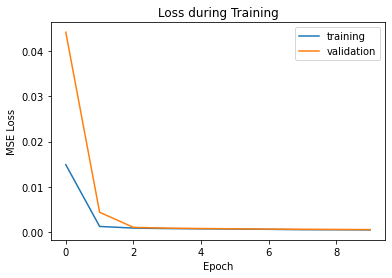

In [23]:
net = SIRNet(input_size=100*2, hidden_size=50, n_hidden_layers=0)
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss, validation_loss = train_network(
    net, train_loader, validation_loader, optimizer, criterion, 10)
plot_losses(train_loss, validation_loss)
plt.title("Loss during Training")
plt.legend()
plt.show()

In [24]:
N_LAYERS = [0, 2, 4]
HIDDEN_SIZES = [10, 50, 100]

for hidden_size in HIDDEN_SIZES:
    for n_layer in N_LAYERS:
        net = SIRNet(input_size=100*2, hidden_size=hidden_size,
                     n_hidden_layers=n_layer)
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        _, validation_loss = train_network(
            net, train_loader, validation_loader, optimizer, criterion, 10)

[0/10] train loss: 0.14396177511662245, validation loss: 0.1280195415019989
[1/10] train loss: 0.1203182723838836, validation loss: 0.1087284077491079
[2/10] train loss: 0.10142590780742466, validation loss: 0.09030823196683611
[3/10] train loss: 0.0834132821764797, validation loss: 0.07348647287913732
[4/10] train loss: 0.06525952031370252, validation loss: 0.05523746992860522
[5/10] train loss: 0.047354737762361765, validation loss: 0.03756764956883022
[6/10] train loss: 0.030730121419765055, validation loss: 0.02261634649974959
[7/10] train loss: 0.017619646299863234, validation loss: 0.012220916604357106
[8/10] train loss: 0.00882237202313263, validation loss: 0.005529037211090326
[9/10] train loss: 0.0041202443244401366, validation loss: 0.0025724738038011958
[0/10] train loss: 0.043289557623211294, validation loss: 0.027066493406891823
[1/10] train loss: 0.018671452620765194, validation loss: 0.009514663767601763
[2/10] train loss: 0.004975717478373554, validation loss: 0.0016378

[0/20] train loss: 0.008336930848599877, validation loss: 0.001747876572023545
[1/20] train loss: 0.0012576391000038711, validation loss: 0.0011059976698431586
[2/20] train loss: 0.0010242966218356742, validation loss: 0.0009512446953782014
[3/20] train loss: 0.0009015260275191395, validation loss: 0.0008603773977873581
[4/20] train loss: 0.0008130638161674142, validation loss: 0.0007076387908974928
[5/20] train loss: 0.0007057710145090823, validation loss: 0.0006241618081860777
[6/20] train loss: 0.0006230499357116059, validation loss: 0.0005351949740932989
[7/20] train loss: 0.0005785290759376949, validation loss: 0.0004985856690577098
[8/20] train loss: 0.0005441181101559778, validation loss: 0.000506710323471842
[9/20] train loss: 0.0005310583337632124, validation loss: 0.00045554310781881213
[10/20] train loss: 0.0005155789431228186, validation loss: 0.00041961950150185397
[11/20] train loss: 0.0005201869344091392, validation loss: 0.00041926229355989823
[12/20] train loss: 0.0005

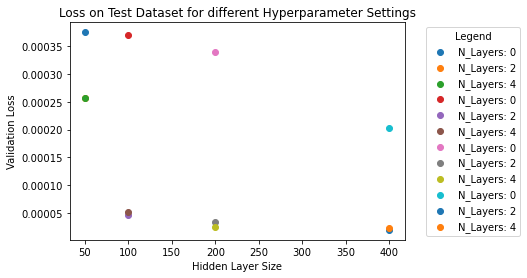

In [25]:
N_LAYERS = [0, 2, 4]
HIDDEN_SIZES = [50, 100, 200, 400]

for hidden_size in HIDDEN_SIZES:
    for n_layer in N_LAYERS:
        net = SIRNet(input_size=100*2, hidden_size=hidden_size,
                     n_hidden_layers=n_layer)
        optimizer = optim.Adam(net.parameters(), lr=0.001)

        _, _ = train_network(
            net, train_loader, validation_loader, optimizer, criterion, 20)
        test_loss = evaluate_network(net, test_loader, criterion)

        plt.scatter(hidden_size, test_loss, label=f'N_Layers: {n_layer}')


plt.xlabel('Hidden Layer Size')
plt.ylabel('Validation Loss')
plt.title('Loss vs Hidden Size')
# Move the legend outside the plot using bbox_to_anchor
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')

plt.title('Loss on Test Dataset for different Hyperparameter Settings')
plt.show()

We see the larger the network the better the performance in our case and we get the best results for 4 layers and a hidden size of 400. We can also observe that having more layers in these tests have a stronger influence on the outcome than the hidden size. For now we stick with our found network parameter since they perform good enough for our case.

Lets now look into variable dataset sizes


[0/20] train loss: 0.01040783877397189, validation loss: 0.0021936005546844433
[1/20] train loss: 0.001487076689954847, validation loss: 0.0013141856595341647
[2/20] train loss: 0.0012598733992490452, validation loss: 0.0012560333790523665
[3/20] train loss: 0.0012139897371525876, validation loss: 0.0012452345274920975
[4/20] train loss: 0.0011880520323757082, validation loss: 0.0011966395624248044
[5/20] train loss: 0.0010775537011795677, validation loss: 0.0011991491025712872
[6/20] train loss: 0.0010228249375359155, validation loss: 0.000997428998484143
[7/20] train loss: 0.0009396754358022008, validation loss: 0.0009502209722995758
[8/20] train loss: 0.0008845835545798764, validation loss: 0.0009231189698246973
[9/20] train loss: 0.000844927977595944, validation loss: 0.0008758673544174858
[10/20] train loss: 0.0008232980871980544, validation loss: 0.0007911486734103944
[11/20] train loss: 0.0007835579090169631, validation loss: 0.0007474457046815328
[12/20] train loss: 0.000736054

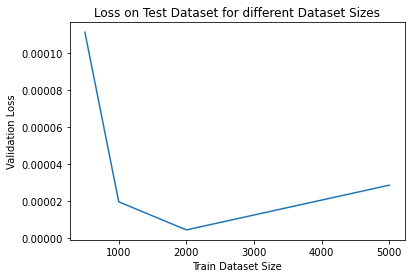

In [26]:
trainset_sizes = [500, 1000, 2000, 5000]
test_losses = []
for train_size in trainset_sizes:
    train_dataset = SIRDataset(size=train_size, T=100)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    net = SIRNet(input_size=100*2, hidden_size=400, n_hidden_layers=4)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    _, _ = train_network(
        net, train_loader, validation_loader, optimizer, criterion, 20)
    test_loss = evaluate_network(net, test_loader, criterion)
    test_losses.append(test_loss)


plt.plot(trainset_sizes, test_losses)

plt.xlabel('Train Dataset Size')
plt.ylabel('Validation Loss')
plt.title('Loss vs Hidden Size')

plt.title('Loss on Test Dataset for different Dataset Sizes')
plt.show()

We can't see any substantial improvements after a dataset size of 1000


## 1.4


In [27]:
class SIRNet(nn.Module):
    def __init__(self, input_size, hidden_size, feature_size, n_hidden_layers):
        super(SIRNet, self).__init__()
        layers = []

        # First layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Final layer
        layers.append(nn.Linear(hidden_size, feature_size))

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        for layer in self.layers:
            x = layer(x)
        return x

In [28]:
def subnet_constructor(input_size, hidden_size, output_size):
    model = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, output_size)
    )
    return model


def ortogonal_matrix(dim):
    Q = special_ortho_group.rvs(dim)
    return torch.Tensor(Q)


class ConditionalCouplingBlock(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.split1 = math.floor(self.input_size/2)
        self.split2 = self.input_size - self.split1
        self.subnet = subnet_constructor(
            self.split1 + self.condition_size, self.hidden_size, 2*self.split2)

    def forward(self, x, cond, rev=False):
        x1, x2 = x[..., :self.split1], x[..., self.split1:]

        params = self.subnet(torch.cat([x1, cond], -1))
        s, t = params[..., :self.split2], params[..., self.split2:]
        s = torch.tanh(s)
        ljd = torch.sum(s, -1)

        if not rev:
            s = torch.exp(s)
            x2 = s*x2 + t
            return torch.cat([x1, x2], -1), ljd
        if rev:
            s = torch.exp(-s)
            x2 = s * (x2-t)
            return torch.cat([x1, x2], -1)


class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, n_blocks, condition_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_blocks = n_blocks
        self.condition_size = condition_size

        self.coupling_blocks = nn.ModuleList([ConditionalCouplingBlock(
            input_size, hidden_size, self.condition_size) for _ in range(n_blocks)])
        self.orthogonal_matrices = [ortogonal_matrix(
            input_size) for _ in range(n_blocks-1)]

    def forward(self, x, cond, rev=False):
        if rev:
            return self._inverse(x, cond)
        return self._forward(x, cond)

    def _forward(self, x, cond):
        ljd = torch.zeros((x.shape[0]))
        for l in range(self.n_blocks-1):
            x, partial_ljd = self.coupling_blocks[l](x, cond)
            ljd += partial_ljd
            x = torch.matmul(x, self.orthogonal_matrices[l])
        x, partial_ljd = self.coupling_blocks[-1](x, cond)
        ljd += partial_ljd
        return x, ljd

    def _inverse(self, x, cond):
        for l in range(self.n_blocks-1, 0, -1):
            x = self.coupling_blocks[l](x, cond, rev=True)
            x = torch.matmul(x, self.orthogonal_matrices[l-1].T)
        x = self.coupling_blocks[0](x, cond, rev=True)
        return x

    def sample(self, num_samples, cond=None):
        samples = []
        if cond is None:
            for c in range(self.condition_size):
                z = torch.normal(mean=torch.zeros(
                    (num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
                samples.append(self._inverse(z, cond=c.repeat(num_samples, 1)))
        else:
            z = torch.normal(mean=torch.zeros(
                (num_samples, self.input_size)), std=torch.ones((num_samples, self.input_size)))
            samples.append(self._inverse(z, cond=cond.repeat(num_samples, 1)))
        return torch.cat(samples, 0)

In [29]:
# conditional real NVP class
class FusionNetwork(nn.Module):
    def __init__(self, input_size, hidden_size_sir, feature_size, n_layers_sir, hidden_size_nvp, input_size_nvp, blocks):
        super(FusionNetwork, self).__init__()

        self.feature_size = feature_size

        self.summary_net = SIRNet(input_size=input_size,
                                  hidden_size=hidden_size_sir,
                                  n_hidden_layers=n_layers_sir,
                                  feature_size=feature_size)

        self.real_nvp = ConditionalRealNVP(input_size=input_size_nvp,
                                           hidden_size=hidden_size_nvp,
                                           n_blocks=blocks,
                                           condition_size=feature_size)

    def forward(self, x, y):
        condition = self.summary_net(x)
        x = self.real_nvp(y, condition)
        return x

    def sample_posterior(self, x, num_samples):
        condition = self.summary_net(x)
        return self.real_nvp.sample(num_samples=num_samples, cond=condition)

In [30]:
def training_per_epoch(model, train_loader, optimizer, batchsize):
    model.train()
    loss_sum = 0
    for input, ground_truth in train_loader:
        optimizer.zero_grad()
        z, ljd = model(input, ground_truth)
        loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batchsize
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    return loss_sum/len(train_loader)


def validation_per_epoch(model, validation_loader, batchsize):
    model.eval()
    loss_sum = 0
    with torch.no_grad():
        for input, ground_truth in validation_loader:
            z, ljd = model(input, ground_truth)
            loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd) / batchsize
            loss_sum += loss.item()
    return loss_sum/len(validation_loader)


def train_fusion(model, train_loader, validation_loader, batchsize=32, epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for epoch in range(epochs):
        train_loss = training_per_epoch(
            model=model, train_loader=train_loader, optimizer=optimizer, batchsize=batchsize)
        validation_loss = validation_per_epoch(
            model=model, validation_loader=validation_loader, batchsize=batchsize)
        train_losses[epoch] = train_loss
        validation_losses[epoch] = validation_loss
        print(
            f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss}")

Training both networks together:


In [31]:
params = {'input_size': 2*100,
          'hidden_size_sir': 200,
          'feature_size': 50,
          'n_layers_sir': 4,
          'hidden_size_nvp': 200,
          'input_size_nvp': 3,
          'blocks': 10}

train_dataset = SIRDataset(size=1000, T=100)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = FusionNetwork(**params)
train_fusion(model, train_loader, validation_loader, epochs=50)

Epoch [1/50], Train Loss: -5.9403, Validation Loss: -7.708082301276071
Epoch [2/50], Train Loss: -8.6171, Validation Loss: -7.561585358210972
Epoch [3/50], Train Loss: -8.6473, Validation Loss: -7.931142330169678
Epoch [4/50], Train Loss: -8.8529, Validation Loss: -8.106215613228935
Epoch [5/50], Train Loss: -9.0384, Validation Loss: -7.954923050744193
Epoch [6/50], Train Loss: -9.5768, Validation Loss: -9.245039531162806
Epoch [7/50], Train Loss: -8.8229, Validation Loss: -8.6531389100211
Epoch [8/50], Train Loss: -9.9701, Validation Loss: -9.343085152762276
Epoch [9/50], Train Loss: -9.4257, Validation Loss: -8.944256850651332
Epoch [10/50], Train Loss: -10.2207, Validation Loss: -9.573261056627546
Epoch [11/50], Train Loss: -10.4497, Validation Loss: -9.329463073185511
Epoch [12/50], Train Loss: -10.3540, Validation Loss: -9.517273357936315
Epoch [13/50], Train Loss: -10.6681, Validation Loss: -8.998717444283622
Epoch [14/50], Train Loss: -8.3493, Validation Loss: -8.584992613111224

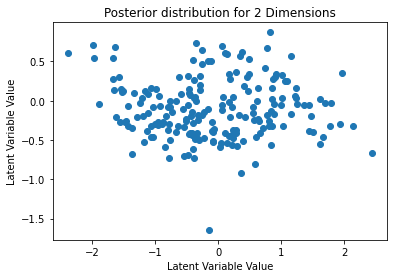

In [32]:
def generate_predictions(model, test_loader):
    model.eval()
    N_samples = len(test_loader)
    latend_space = torch.zeros((N_samples, 3))
    ground_truths = torch.zeros((N_samples, 3))
    with torch.no_grad():
        for i, (input, ground_truth) in enumerate(test_loader):
            z, _ = model(input, ground_truth)
            latend_space[i] = z
            ground_truths[i] = ground_truth
    return latend_space.numpy(), ground_truths.numpy()


test_dataset = SIRDataset(size=200, T=100)
test_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

latend_space, _ = generate_predictions(model=model, test_loader=test_loader)
plt.scatter(latend_space[:, 0], latend_space[:, 1])
plt.title('Posterior distribution for 2 Dimensions')
plt.xlabel('Latent Variable Value')
plt.ylabel('Latent Variable Value')

plt.show()

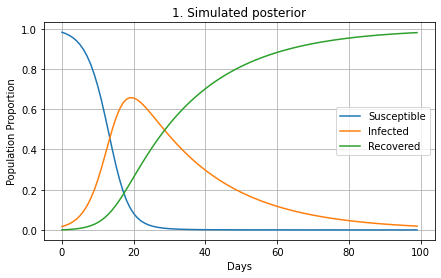

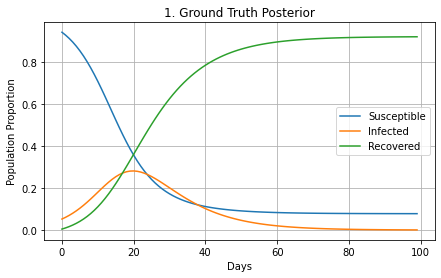

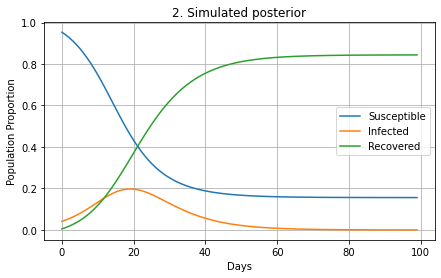

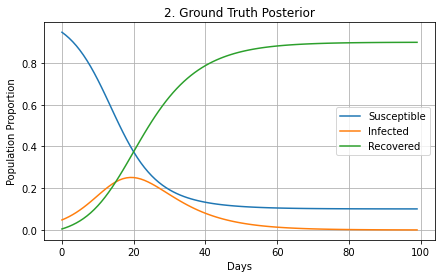

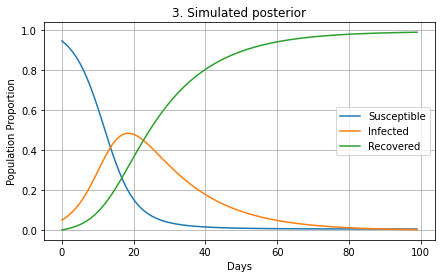

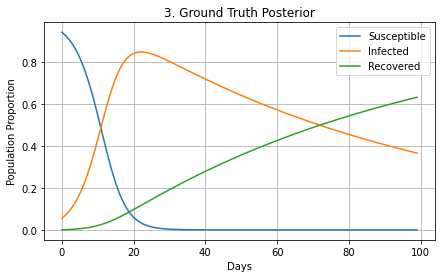

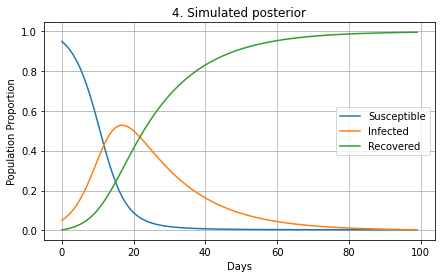

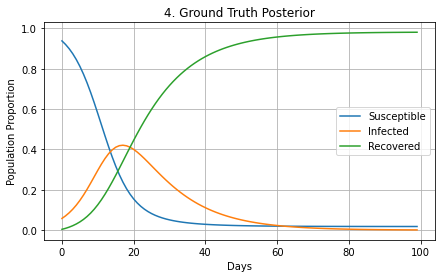

In [33]:
test_dataset = SIRDataset(size=10, T=100)
for i in range(4):
    input, ground_truth = test_dataset[i]
    input = input.unsqueeze(0)
    ground_truth = ground_truth.unsqueeze(0)
    with torch.no_grad():
        posterior = model.sample_posterior(input, 1)
    posterior = posterior.squeeze(0).numpy()
    ground_truth = ground_truth.squeeze(0).numpy()

    _, C = simulate_sir_simple(posterior[0], posterior[1], posterior[2], num_days)
    _, C_truth = simulate_sir_simple(
        ground_truth[0], ground_truth[1], ground_truth[2], num_days)

    plot_sir_simulation(C, title=f'{i+1}. Simulated posterior')
    plot_sir_simulation(C_truth, title=f'{i+1}. Ground Truth Posterior')

We see, while looking at 4 different test samples, the network is able to predict values that resemble the ground truth values. Lets now take a look at the actual posterior distribution 

## 1.5

In [34]:
def plot_empirical_cdf(samples_posterior,ground_truth, bins = 50):
    fig, axs = plt.subplots(1,3, figsize=(12,3))
    parameter = ['lambda', 'mu', 'I_0']
    for i in range(len(parameter)):
        single_posterior = samples_posterior[:,i]
        truth = ground_truth[i]

        single_posterior = np.sort(single_posterior)
        counts, bin_edges = np.histogram(single_posterior, bins=bins, density=True)
        cdf = np.cumsum(counts) * np.diff(bin_edges)

        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        axs[i].plot(bin_centers, cdf, label='Empirical CDF')
        axs[i].axvline(x=truth, color='r', linestyle='--', label='Ground Truth')
        axs[i].set_xlabel('Sample Values')
        axs[i].set_ylabel('Cumulative Probability')
        axs[i].set_title(f'Empirical CDF for {parameter[i]} Samples')
        axs[i].legend()
    plt.show()

def plot_histograms(samples_posterior,ground_truth, bins = 50):
    fig, axs = plt.subplots(1,3, figsize=(12,3))
    parameter = ['lambda', 'mu', 'I_0']
    for i in range(len(parameter)):
        single_posterior = samples_posterior[:,i]
        truth = ground_truth[i]
        axs[i].hist(single_posterior, bins=bins, alpha=0.7, color='blue')
        axs[i].axvline(x=truth, color='r',linestyle='--', label="ground truth")
        axs[i].set_title(f'{parameter[i]} Latent Space Variables')
        axs[i].set_xlabel('Latent Variable Value')
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
    plt.show()

X Test Sample 1


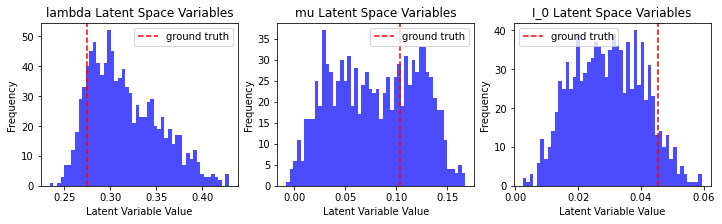

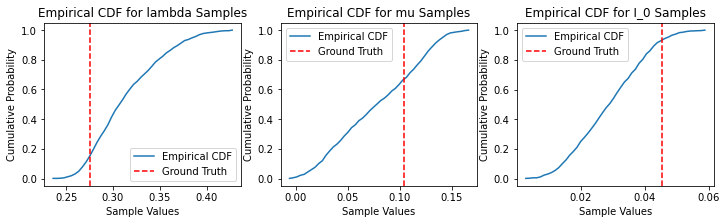

X Test Sample 2


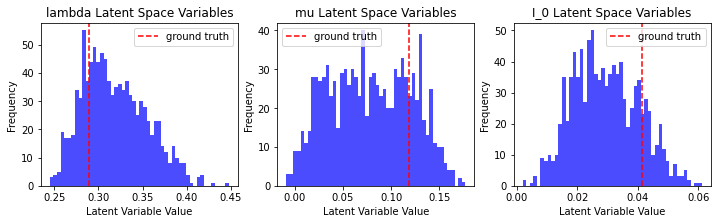

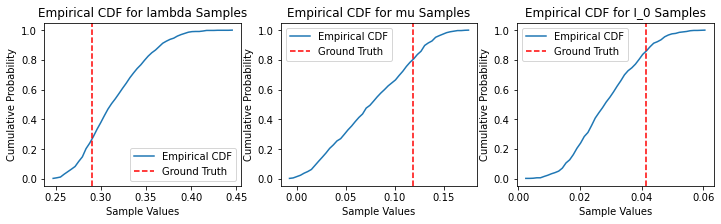

X Test Sample 3


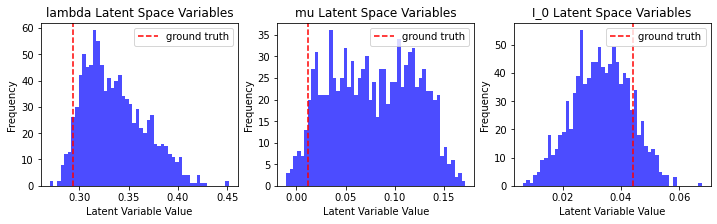

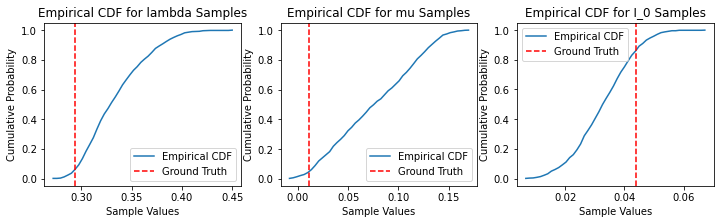

X Test Sample 4


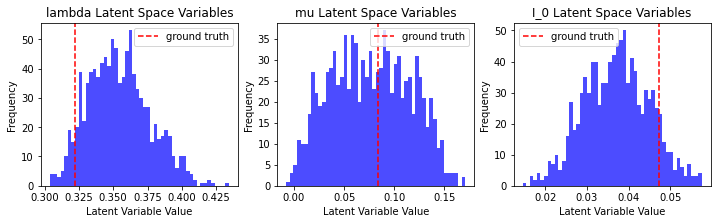

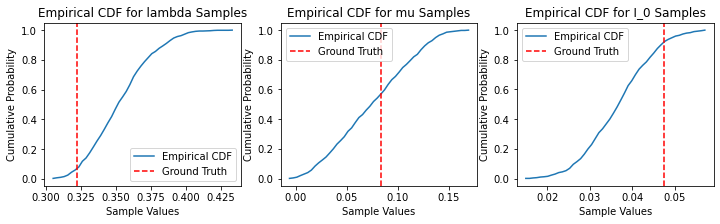

In [35]:
for i in range(4):
    
    input, ground_truth = test_dataset[i]
    input = input.unsqueeze(0)
    ground_truth = ground_truth.unsqueeze(0)
    n_samples = 1000
    with torch.no_grad():
        samples_posterior = model.sample_posterior(input, n_samples)
    samples_posterior = samples_posterior.numpy()
    ground_truth = ground_truth.squeeze(0).numpy()
    print(f'X Test Sample {i+1}')
    
    plot_histograms(samples_posterior=samples_posterior,
                    ground_truth=ground_truth,
                    bins=50)

    plot_empirical_cdf(samples_posterior=samples_posterior,
                       ground_truth=ground_truth,
                       bins=50)
    
    
    

    plt.show()

The marginal distribution are look mostly good calibrated. We see the worst performance in lambda values at Test samples 1 and 2

## 1.6

In [36]:
for i in range(4):
    
    input, ground_truth = test_dataset[i]
    input = input.unsqueeze(0)
    ground_truth = ground_truth.unsqueeze(0)
    with torch.no_grad():
        samples_posterior = model.sample_posterior(input, 200)
    samples_posterior = samples_posterior.numpy()
    ground_truth = ground_truth.squeeze(0).numpy()
    print(f'X Test Sample {i+1}')
    n_samples = len(samples_posterior)
    T = 100
    C_k = np.zeros((n_samples,T,3))
    for j in range(len(samples_posterior)):
        _, C = simulate_sir_simple(lam=samples_posterior[j,0],
                            mu=samples_posterior[j,1],
                            I_0=samples_posterior[j,2],
                            T=T)
        C_k[j,:,:] = C
    lower_bound = np.percentile(C_k, 2.5, axis=0)
    upper_bound = np.percentile(C_k, 97.5, axis=0)
    _, ground_truth_C = simulate_sir_simple(lam=ground_truth[0],
                            mu=ground_truth[1],
                            I_0=ground_truth[2],
                            T=T)
    is_within_interval = (lower_bound <= ground_truth_C) & (ground_truth_C <= upper_bound)
    is_C_in_intervall = np.all(is_within_interval)
    print(f'Ground Truth C is in predicted Confidence Intervall: {is_C_in_intervall}')


X Test Sample 1
Ground Truth C is in predicted Confidence Intervall: True
X Test Sample 2
Ground Truth C is in predicted Confidence Intervall: True
X Test Sample 3
Ground Truth C is in predicted Confidence Intervall: False
X Test Sample 4
Ground Truth C is in predicted Confidence Intervall: True


# 2. Noisy data


# 3. Model misspecification detection


In [37]:
def mmd_loss(x, y, kernel):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "rbf" or "inverse-multi-quadratic"
    """
    # Compute squared Euclidean distances

    xx, yy, zz = torch.mm(x, x.T), torch.mm(y, y.T), torch.mm(x, y.T)
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.T + rx - 2. * xx  
    dyy = ry.T + ry - 2. * yy  
    dxy = rx.T + ry - 2. * zz  

    XX, YY, XY = (torch.zeros(xx.shape),
                  torch.zeros(xx.shape),
                  torch.zeros(xx.shape))

    # Squared Exponential or Gaussian Kernel
    if kernel == "rbf":
        #bandwidth_range = [10, 15, 20, 50,100]
        bandwidth_range = [10, 15, 20, 25, 30]
        XX = sum(torch.exp(-0.5 * dxx / a) for a in bandwidth_range)
        YY = sum(torch.exp(-0.5 * dyy / a) for a in bandwidth_range)
        XY = sum(torch.exp(-0.5 * dxy / a) for a in bandwidth_range)

    # Inverse Multi-Quadratic Kernel
    if kernel == "inverse-multi-quadratic":
        #bandwidth_range = [10, 15, 20, 50,100]
        bandwidth_range = [10, 15, 20, 25, 30]
        XX = sum(1 / (dxx / a + 1) for a in bandwidth_range)
        YY = sum(1 / (dyy / a + 1) for a in bandwidth_range)
        XY = sum(1 / (dxy / a + 1) for a in bandwidth_range)

    return torch.mean(XX + YY - 2. * XY)

def nll_loss(z, ljd):
    loss = torch.sum(0.5*torch.sum(z**2, -1)-ljd)
    return loss


In [87]:
def training_per_epoch(model, train_loader, optimizer, batchsize):
    model.train()
    loss_sum = 0
    for input, ground_truth in train_loader:
        optimizer.zero_grad()
        condition = model.summary_net(input)
        z, ljd = model.real_nvp(ground_truth, condition)
        loss = nll_loss(z,ljd) / batchsize

        standard_gaussian = torch.randn(condition.shape)
        loss += mmd_loss(condition, standard_gaussian,  kernel='rbf')
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    return loss_sum/len(train_loader)


def validation_per_epoch(model, validation_loader, batchsize):
    model.eval()
    loss_sum = 0
    with torch.no_grad():
        for input, ground_truth in validation_loader:
            condition = model.summary_net(input)
            z, ljd = model.real_nvp(ground_truth, condition)
            loss = nll_loss(z,ljd) / batchsize
            standard_gaussian = torch.randn(condition.shape)
            #standard_gaussian = torch.normal(mean=0, std=1, size=(condition.shape))
            loss += mmd_loss(condition, standard_gaussian,  kernel='rbf')
            loss_sum += loss.item()
    return loss_sum/len(validation_loader)


def train_fusion(model, train_loader, validation_loader, batch_size=32, epochs=10, learning_rate=0.001):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)
    for epoch in range(epochs):
        train_loss = training_per_epoch(
            model=model, train_loader=train_loader, optimizer=optimizer, batchsize=batch_size)
        validation_loss = validation_per_epoch(
            model=model, validation_loader=validation_loader, batchsize=batch_size)
        train_losses[epoch] = train_loss
        validation_losses[epoch] = validation_loss
        print(
            f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss}")

In [88]:
params = {'input_size': 2*100,
          'hidden_size_sir': 50,
          'feature_size': 20,
          'n_layers_sir': 2,
          'hidden_size_nvp': 200,
          'input_size_nvp': 3,
          'blocks': 10}

training_params = {'batch_size': 32,
                   'epochs': 200,
                   'learning_rate': 0.0005,
                   'train_loader': train_loader,
                   'validation_loader': validation_loader}

train_dataset = SIRDataset(size=1000, T=100)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = FusionNetwork(**params)
train_fusion(model, **training_params)

Epoch [1/200], Train Loss: -4.0163, Validation Loss: -6.070144193513053
Epoch [2/200], Train Loss: -7.4667, Validation Loss: -6.952042034694126
Epoch [3/200], Train Loss: -7.6734, Validation Loss: -6.957410880497524
Epoch [4/200], Train Loss: -7.7243, Validation Loss: -6.811998605728149
Epoch [5/200], Train Loss: -7.7879, Validation Loss: -6.860429883003235
Epoch [6/200], Train Loss: -8.0267, Validation Loss: -7.720256584031241
Epoch [7/200], Train Loss: -8.7615, Validation Loss: -8.109906588281904
Epoch [8/200], Train Loss: -9.1128, Validation Loss: -8.591284683772496
Epoch [9/200], Train Loss: -9.3167, Validation Loss: -8.583381618772234
Epoch [10/200], Train Loss: -9.3139, Validation Loss: -8.608196871621269
Epoch [11/200], Train Loss: -9.5936, Validation Loss: -8.962577053478785
Epoch [12/200], Train Loss: -9.6517, Validation Loss: -8.933812703405108
Epoch [13/200], Train Loss: -9.9012, Validation Loss: -7.042387383324759
Epoch [14/200], Train Loss: -9.6555, Validation Loss: -9.051

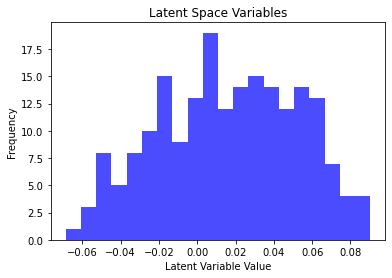

In [80]:
def plot_hx_histogram(observed_values, bins = 20):
    plt.hist(observed_values, bins=bins, alpha=0.7, color='blue')
    plt.title(f'Latent Space Variables')
    plt.xlabel('Latent Variable Value')
    plt.ylabel('Frequency')
    plt.show()

observed_values = np.zeros((model.feature_size, len(test_loader)))
for i ,(data, targets) in enumerate(test_loader):
        with torch.no_grad():
            observed_values[:, i] = model.summary_net(data)

plot_hx_histogram(observed_values[2,:])
        



In [59]:
import scipy.stats as stats
def check_chi_test(fusion_model, test_loader, significance_level=0.01):
    p_values = []
    n_bins = 20
    observed_values = np.zeros((fusion_model.feature_size, len(test_loader)))
    for i ,(data, targets) in enumerate(test_loader):
        with torch.no_grad():
            observed_values[:, i] = fusion_model.summary_net(data)
    
    for i in range(fusion_model.feature_size):
        observed_counts, bin_edges = np.histogram(observed_values[i,:], bins=n_bins, density=False)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        expected_probs = np.zeros(n_bins)
        for i in range(n_bins):
            expected_probs[i] = stats.norm.cdf(bin_edges[i], 0, 1) - stats.norm.cdf(bin_edges[i+1], 0, 1)

        # Convert probabilities to counts
        expected_counts = len(observed_values[i, :]) * expected_probs
        
        chi_stat, chi_p_value = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)
        p_values.append(chi_p_value)

    if any(p > significance_level for p in p_values):
        print("Null hypothesis cannot be rejected for at least one batch. h(X) follows a normal distribution.")
    else:
        print("Null hypothesis is rejected for all batches")





check_chi_test(model, test_loader, 0.01)

Null hypothesis cannot be rejected for at least one batch. h(X) follows a normal distribution.


# 4. Sensitivity analysis
